In [1]:
import numpy as np
import pandas as pd
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt

# Load Data

In [2]:
df = pd.read_csv(pm.get_data("babies.csv"))

<Axes: xlabel='Month', ylabel='Length'>

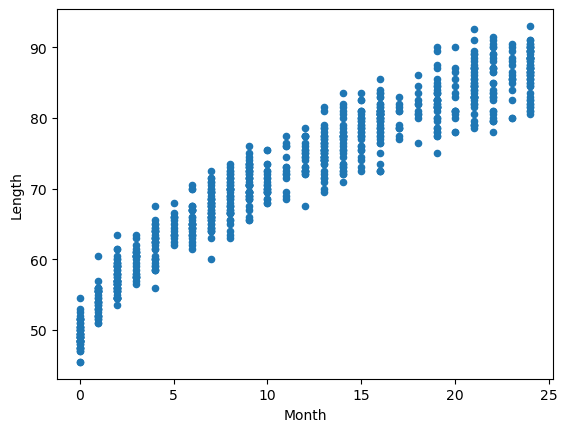

In [3]:
df.plot.scatter(x='Month', y='Length')

In [15]:
with pm.Model() as linear_model:
    month = pm.Data('month', df.Month)
    length = pm.Data('length', df.Length)

    intercept = pm.Normal('intercept', mu=45, sigma=10)
    slope = pm.HalfNormal('slope', sigma=10)
    quad_slope = pm.HalfNormal('quad_slope', sigma=0.1)
    mu = pm.Deterministic('mu', intercept + slope * month - quad_slope * month ** 2)
    sigma = pm.Exponential('sigma', lam=1)

    length_hat = pm.Normal('length_hat', mu=mu, sigma=sigma, observed=length)

/Users/jessegrabowski/mambaforge/envs/cge-dev/lib/python3.11/site-packages/pymc/data.py:433: UserWarning: The `mutable` kwarg was not specified. Before v4.1.0 it defaulted to `pm.Data(mutable=True)`, which is equivalent to using `pm.MutableData()`. In v4.1.0 the default changed to `pm.Data(mutable=False)`, equivalent to `pm.ConstantData`. Use `pm.ConstantData`/`pm.MutableData` or pass `pm.Data(..., mutable=False/True)` to avoid this warning.
  warnings.warn(


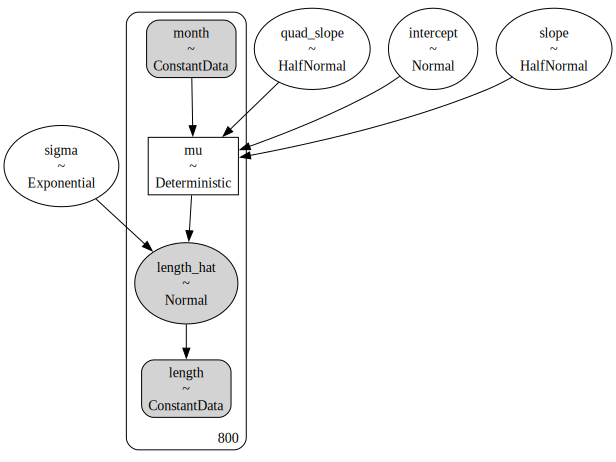

In [16]:
pm.model_to_graphviz(linear_model)

In [17]:
with linear_model:
    prior = pm.sample_prior_predictive()

Sampling: [intercept, length_hat, quad_slope, sigma, slope]


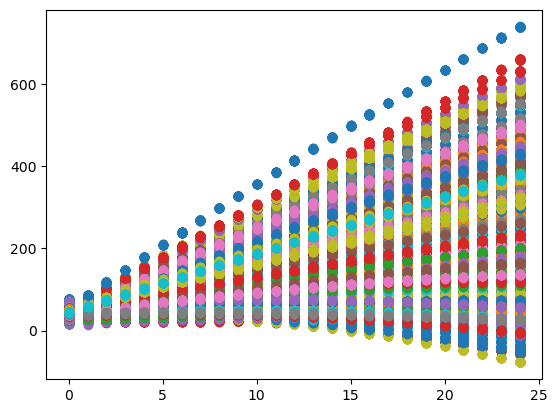

In [18]:
for draw in prior.prior_predictive.length_hat.values.squeeze():
    plt.scatter(df.Month, draw)

In [19]:
with linear_model:
    idata = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope, quad_slope, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


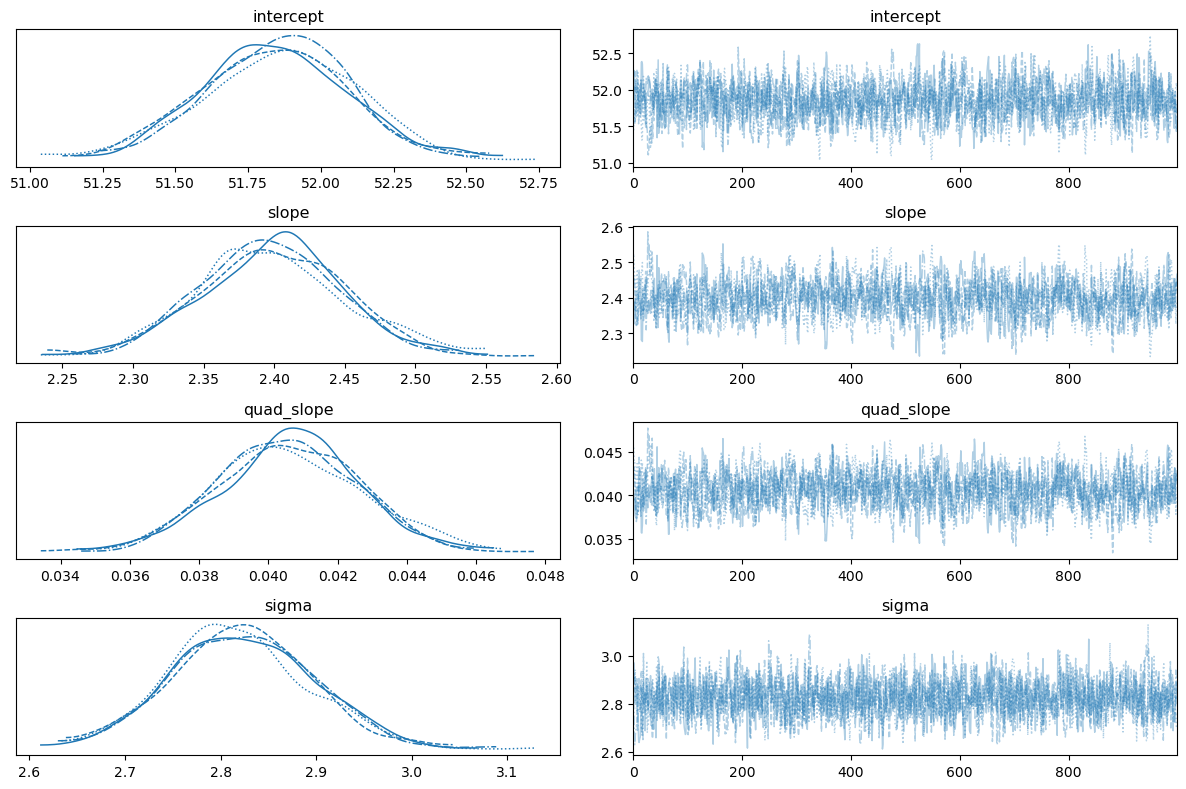

In [20]:
az.plot_trace(idata, var_names=['~mu']);
plt.tight_layout()
plt.show()

In [21]:
az.summary(idata, var_names=['~mu'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,51.849,0.253,51.355,52.293,0.007,0.005,1170.0,1760.0,1.0
slope,2.398,0.051,2.304,2.494,0.002,0.001,1039.0,1520.0,1.0
quad_slope,0.041,0.002,0.037,0.044,0.000,0.000,1102.0,1576.0,1.0
sigma,2.821,0.073,2.684,2.958,0.002,0.001,1966.0,1916.0,1.0


In [22]:
with linear_model:
    idata = pm.sample_posterior_predictive(idata, extend_inferencedata=True)

Sampling: [length_hat]


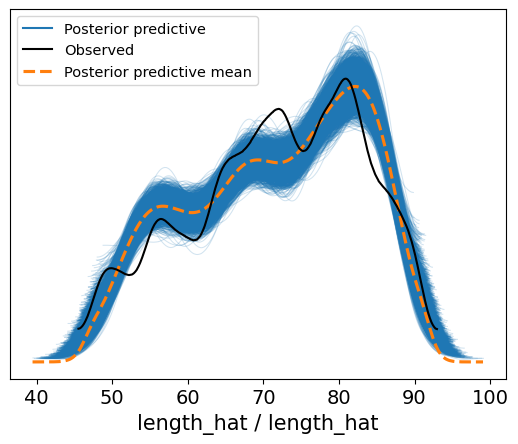

In [23]:
az.plot_ppc(idata);

In [24]:
mu_length = idata.posterior_predictive.length_hat.mean(dim=['chain', 'draw'])
hdi_length = az.hdi(idata.posterior_predictive, hdi_prob=0.94).length_hat

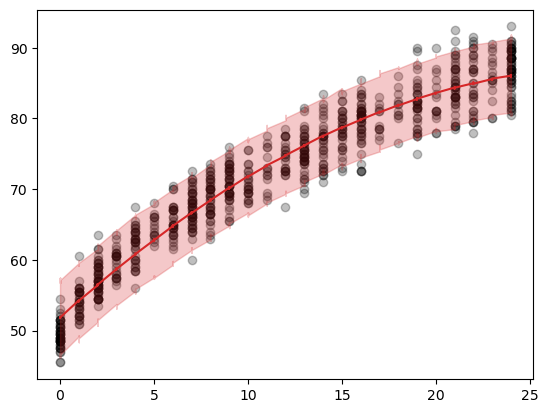

In [25]:
fig, ax = plt.subplots()
ax.plot(df.Month, mu_length, zorder=1000, color='tab:red')
ax.scatter(df.Month, df.Length, alpha=0.25, color='k')
ax.fill_between(df.Month, *hdi_length.values.T, alpha=0.25, color='tab:red')